In [1]:
import os, shutil, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ============================
# 1) Paths & Hyperparameters
# ============================
root_dir = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"
working_dir = "/kaggle/working/Malimg_split"
batch_size = 128
num_epochs = 20
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ============================
# 2) Split Dataset (70/15/15)
# ============================
def split_dataset():
    splits = ["train", "val", "test"]
    ratios = [0.7, 0.15, 0.15]
    os.makedirs(working_dir, exist_ok=True)
    for s in splits:
        os.makedirs(os.path.join(working_dir, s), exist_ok=True)

    for cls in os.listdir(root_dir):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir): continue

        files = os.listdir(cls_dir)
        random.shuffle(files)
        n_total = len(files)
        n_train = int(ratios[0]*n_total)
        n_val   = int(ratios[1]*n_total)

        split_files = {
            "train": files[:n_train],
            "val": files[n_train:n_train+n_val],
            "test": files[n_train+n_val:]
        }

        for split, fs in split_files.items():
            os.makedirs(os.path.join(working_dir, split, cls), exist_ok=True)
            for f in fs:
                shutil.copy(os.path.join(cls_dir,f), os.path.join(working_dir,split,cls,f))

if not os.path.exists(os.path.join(working_dir,"train")):
    split_dataset()
    print("Dataset split complete!")

Dataset split complete!


In [4]:
# ============================
# 3) Transforms (Grayscale -> RGB)
# ============================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [5]:
# ============================
# 4) Dataset & DataLoader
# ============================
train_dataset = datasets.ImageFolder(f"{working_dir}/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(f"{working_dir}/val",   transform=val_transform)
test_dataset  = datasets.ImageFolder(f"{working_dir}/test",  transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

# Compute class weights
labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Weighted sampler
sample_weights = [1.0/class_weights[label].item() for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# ============================
# 5) Load Pretrained ResNet50
# ============================
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [7]:
# ============================
# 6) Training Loop
# ============================
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0,0,0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _,pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100.*correct/total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0,0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _,pred = outputs.max(1)
            val_correct += pred.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100.*val_correct/val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss {total_loss/len(train_loader):.4f} Acc {train_acc:.2f}% | Val Loss {val_loss/len(val_loader):.4f} Acc {val_acc:.2f}%")

torch.save(model.state_dict(), "resnet50_malimg.pth")
print("Model saved!")

Epoch [1/20] Train Loss 0.9293 Acc 94.79% | Val Loss 0.5213 Acc 86.32%
Epoch [2/20] Train Loss 0.2536 Acc 99.17% | Val Loss 0.4779 Acc 91.00%
Epoch [3/20] Train Loss 0.1515 Acc 99.56% | Val Loss 0.2497 Acc 95.97%
Epoch [4/20] Train Loss 0.1260 Acc 99.48% | Val Loss 0.3774 Acc 95.03%
Epoch [5/20] Train Loss 0.1800 Acc 99.49% | Val Loss 0.2720 Acc 96.62%
Epoch [6/20] Train Loss 0.1318 Acc 99.54% | Val Loss 0.1497 Acc 96.83%
Epoch [7/20] Train Loss 0.1086 Acc 99.72% | Val Loss 0.1599 Acc 97.41%
Epoch [8/20] Train Loss 0.1331 Acc 99.26% | Val Loss 0.1506 Acc 96.90%
Epoch [9/20] Train Loss 0.0935 Acc 99.66% | Val Loss 0.1841 Acc 96.98%
Epoch [10/20] Train Loss 0.0829 Acc 99.80% | Val Loss 0.1435 Acc 97.70%
Epoch [11/20] Train Loss 0.0654 Acc 99.82% | Val Loss 0.2160 Acc 96.83%
Epoch [12/20] Train Loss 0.0963 Acc 99.74% | Val Loss 0.1446 Acc 97.41%
Epoch [13/20] Train Loss 0.0754 Acc 99.74% | Val Loss 0.1474 Acc 97.12%
Epoch [14/20] Train Loss 0.1254 Acc 99.59% | Val Loss 0.2631 Acc 95.61%
E

In [8]:
# ============================
# 7) Evaluation
# ============================
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _,pred = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())

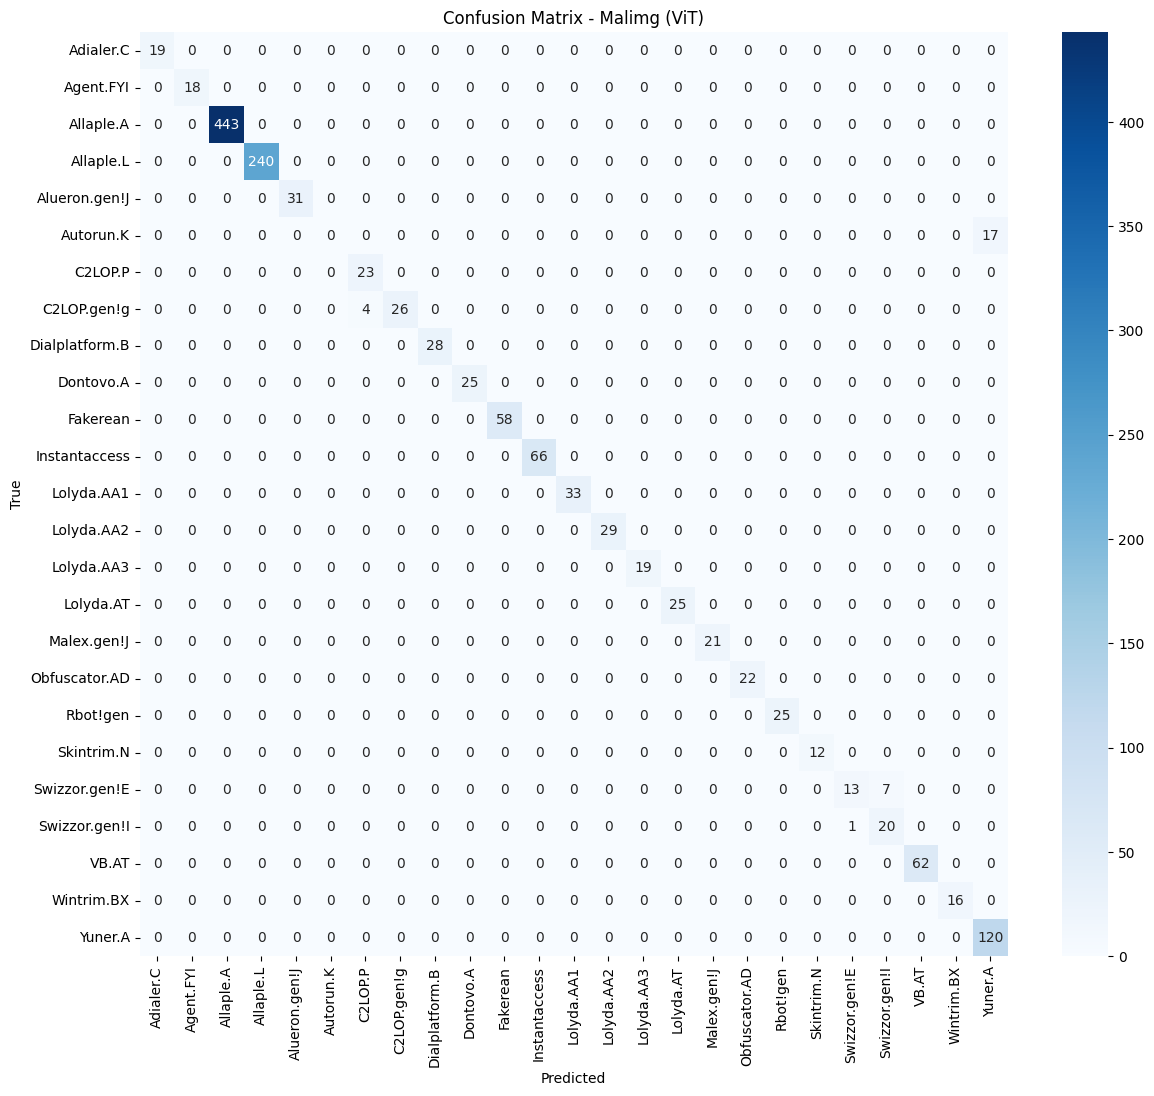

In [9]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - Malimg (ViT)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


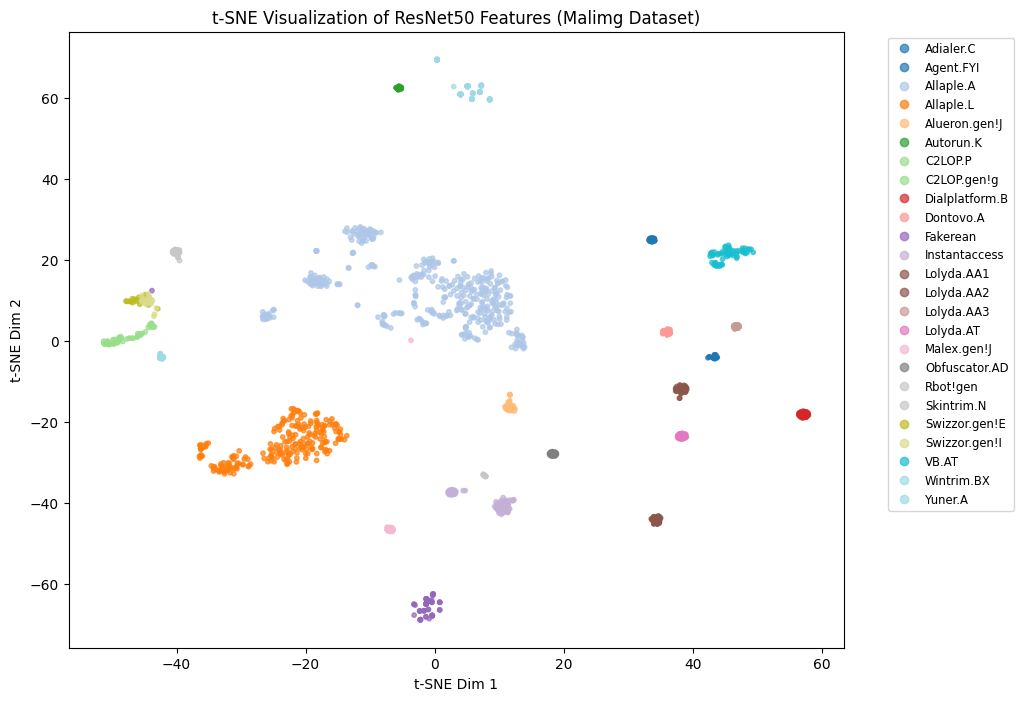

In [10]:
from sklearn.manifold import TSNE

# ============================
# 8) Extract Features for t-SNE
# ============================
model.eval()
features, labels_list = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        # Pass through backbone (without final FC)
        feats = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(
                    model.maxpool(model.relu(model.bn1(model.conv1(imgs)))))))))
        feats = torch.flatten(feats, 1)  # flatten
        features.append(feats.cpu().numpy())
        labels_list.extend(labels.numpy())

features = np.concatenate(features, axis=0)
labels_list = np.array(labels_list)

# ============================
# 9) Run t-SNE
# ============================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_iter=1000)
features_tsne = tsne.fit_transform(features)

# ============================
# 10) Plot t-SNE
# ============================
plt.figure(figsize=(10,8))
scatter = plt.scatter(features_tsne[:,0], features_tsne[:,1],
                      c=labels_list, cmap="tab20", s=10, alpha=0.7)

# Legend
handles, _ = scatter.legend_elements(num=len(class_names))
plt.legend(handles, class_names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")

plt.title("t-SNE Visualization of ResNet50 Features (Malimg Dataset)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()
